# SME0878 - MINERAÇÃO ESTATÍSTICA DE DADOS

TRABALHO 5

Nomes:
Aimê Gomes da Nobrega (Nro USP 11882429) <br>
Adriane Akemi Yamaguti (Nro USP 11915623)

Professor: Jorge Luis Bazan

---

## Importação das bibliotecas

Primeiramente, carregamos as bibliotecas:

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

## Leitura dos dados

Realizamos a leitura dos dados de 10 clientes que fazem compras para o café entre 4 produtos disponíveis, com transações de no máximo 3 itens.

In [4]:
data = pd.read_csv('https://www.ufrgs.br/wiki-r/images/d/dd/Transacoes.csv', sep=',')

Verificamos o tamanho do dataset e as primeiras linhas:

In [8]:
print(f'O dataset possui {data.shape[0]} linhas e {data.shape[1]} colunas')
print('Dataset inteiro:')
data

O dataset possui 10 linhas e 3 colunas
Dataset inteiro:


,Produto01,Produto02,Produto03
0,pao,leite,NaN
1,pao,leite,NaN
2,pao,leite,NaN
3,pao,leite,NaN
4,pao,leite,NaN
5,pao,leite,NaN
6,pao,leite,NaN
7,pao,leite,NaN
8,pao,queijo,NaN
9,pao,queijo,salame


## Criando um modelo de associação

In [19]:
data_list = pd.read_csv('https://www.ufrgs.br/wiki-r/images/d/dd/Transacoes.csv', sep='\t', header=None)
# Renomeando a coluna
data_list.rename(columns={0: 'Items'}, inplace = True)

In [20]:
# Removemos a primeira linha
data_list.drop(axis=0, inplace=True, index=0)
# Resetamos o índice
data_list.reset_index(drop= True, inplace=True)
# Mostramos as primeiras linhas e o tamanho do conjunto de dados
print(data_list.shape)
data_list.head()

(10, 1)


,Items
0,"pao,leite"
1,"pao,leite"
2,"pao,leite"
3,"pao,leite"
4,"pao,leite"


Separamos cada linha em uma lista de itens de cada consumidor por meio da função ```.split()```. Em seguida, criamos uma coluna indicando a quantidade de itens comprados e visualimos as primeiras linhas:

In [21]:
data_list['Items'] = data_list['Items'].apply(lambda row: row.split(','))
data_list['Items_length'] = data_list['Items'].apply(len)
data_list

,Items,Items_length
0,"[pao, leite]",2
1,"[pao, leite]",2
2,"[pao, leite]",2
3,"[pao, leite]",2
4,"[pao, leite]",2
5,"[pao, leite]",2
6,"[pao, leite]",2
7,"[pao, leite]",2
8,"[pao, queijo]",2
9,"[pao, queijo, salame]",3


In [24]:
data_list['Items_length'].value_counts()

2    9
3    1
Name: Items_length, dtype: int64

Passamos a lista de compras de cada consumidor em uma única lista:

In [22]:
lista_compras = [x for x in data_list['Items']]
lista_compras

[['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'leite'],
 ['pao', 'queijo'],
 ['pao', 'queijo', 'salame']]

In [30]:
temp_df = data_list.explode('Items')

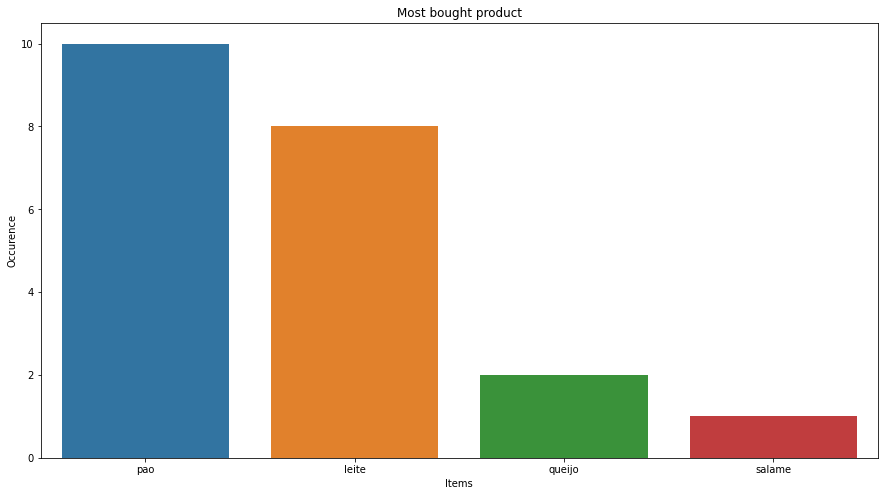

In [32]:
plt.figure(figsize=(15,8))
plt.title('Most bought product')
plot = sns.barplot(x=temp_df['Items'].value_counts().head(10).index, y=temp_df['Items'].value_counts().head(10))
plt.xlabel('Items')
plt.ylabel('Occurence')
plt.savefig('top_prod.png')

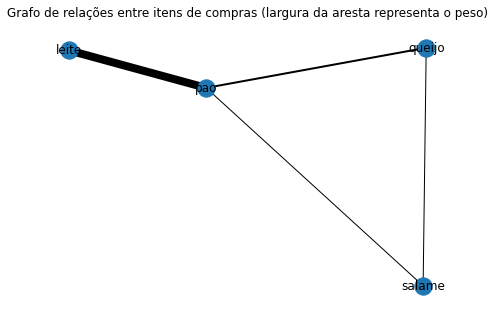

In [45]:
import networkx as nx

grafo = nx.Graph()

# Adiciona todos os itens como nós do grafo
for transaction in data_list:
    for item in transaction:
        grafo.add_node(item)

# Conta a frequência de cada par de itens e adiciona como peso das arestas
for transaction in data_list:
    for i in range(len(transaction)):
        for j in range(i+1, len(transaction)):
            if grafo.has_edge(transaction[i], transaction[j]):
                # Se a aresta já existe, adiciona 1 ao peso atual
                grafo[transaction[i]][transaction[j]]['weight'] += 1
            else:
                # Se a aresta não existe, cria a aresta com peso 1
                grafo.add_edge(transaction[i], transaction[j], weight=1)

# Plota o grafo com os pesos das arestas
pos = nx.spring_layout(grafo)
weights = [grafo[u][v]['weight'] for u, v in grafo.edges()]
nx.draw(grafo, pos, with_labels=True, width=weights)
plt.title('Grafo de relações entre itens de compras (largura da aresta representa o peso)')
plt.show()


Criamos uma instância de um codificador de transação (te) e passamos a variável ```lista_compras``` dentro de um array (te_ary) que transforma a lista de transações em uma matriz binária no qual cada coluna representa um item único e cada linha representa uma transação.

Dessa forma, determinamos se o item está presente (True) ou ausente (False) em cada compra.

In [40]:
# One-hot encode data in pandas dataframe
te = TransactionEncoder()
te_ary = te.fit(lista_compras).transform(lista_compras)

In [41]:
# Converte o array em um dataframe
transaction_group = pd.DataFrame(te_ary, columns=te.columns_)
transaction_group.head()

,leite,pao,queijo,salame
0,True,True,False,False
1,True,True,False,False
2,True,True,False,False
3,True,True,False,False
4,True,True,False,False


## Regras de associação obtidas do algoritmo Apriori

Obtemos valor de suporte e os conjuntos de itens disponíveis. Note que fixamos o suporte mínimo (min_support=0.01) e os itens que forem inferior a min_support serão removidos da análise. Também definimos o comprimento máximo dos conjuntos de itens gerados (max_len = 3).

In [42]:
freq_itemsets = apriori(transaction_group, min_support=0.01, use_colnames=True, max_len = 3)
freq_itemsets['length'] = freq_itemsets['itemsets'].apply(lambda x : len(x))
freq_itemsets

,support,itemsets,length
0,0.8,(leite),1
1,1.0,(pao),1
2,0.2,(queijo),1
3,0.1,(salame),1
4,0.8,"(pao, leite)",2
5,0.2,"(pao, queijo)",2
6,0.1,"(salame, pao)",2
7,0.1,"(salame, queijo)",2
8,0.1,"(salame, pao, queijo)",3


Geramos as regras de associação a partir de um conjunto de item frequentes com o algoritmo a priori. Utilizamos a métrica  "lift" para medir a força da relação entre os antecedentes e consequentes.

In [43]:
rules = association_rules(freq_itemsets, metric="lift", min_threshold = 1)

Por fim, criamos uma tabela com as informações resumidas as regras de associação do algoritmo apriori. são elas:

- 'antecedents': itens antecedentes;

- 'consequents': itens consequentes;

- 'support': mede a frequência de ocorrência entre antecedents e consequents em todas as transações;

- 'confidence': mede a probabilidade do item em 'consequents' apareça em uma transação, dado que o(s) item(ns) em 'antecedents' também apareça na mesma transação;

- 'lift': mede a força da relação entre 'antecedents' e 'consequents', levando em consideração a frequência de ocorrência de cada item individualmente;

- 'leverage': mede o desvio da ocorrência observada em relação a ocorrência esperada, assumindo que 'antecedents' e 'consequents' são independentes;

- 'conviction': mede a dependência entre 'antecedents' e 'consequents', levando em consideração a frequência de ocorrência de cada item individualmente.

In [44]:
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']]

,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(pao),(leite),0.8,0.8,1.0,0.00,1.0
1,(leite),(pao),0.8,1.0,1.0,0.00,inf
2,(pao),(queijo),0.2,0.2,1.0,0.00,1.0
3,(queijo),(pao),0.2,1.0,1.0,0.00,inf
4,(salame),(pao),0.1,1.0,1.0,0.00,inf
5,(pao),(salame),0.1,0.1,1.0,0.00,1.0
6,(salame),(queijo),0.1,1.0,5.0,0.08,inf
7,(queijo),(salame),0.1,0.5,5.0,0.08,1.8
8,"(salame, pao)",(queijo),0.1,1.0,5.0,0.08,inf
9,"(salame, queijo)",(pao),0.1,1.0,1.0,0.00,inf


Dessa forma, temos que as pessoas que compram leite têm alta probabilidade de comprar pão. Já quem compra pão, tem mais chance de comprar leite do que salame ou salame e queijo.